In [1]:
import os
import sys
from tqdm import tqdm,tnrange
import time
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
from music21 import *
import shutil
#from utilities.constants import *
#from utilities.utilities import *

WORKING_DIR = os.path.abspath("")
SCORES_DIR = os.path.join(WORKING_DIR,"scores")
PLOTS_DIR = os.path.join(WORKING_DIR,"plots")
DIRECTION = "desc"
DISTANCE_TH = 3

if not os.path.exists(SCORES_DIR):
    raise ValueError("Download the scores first")


music21: Certain music21 functions might need the optional package scipy;
                  if you run into errors, install it by following the instructions at
                  http://mit.edu/music21/doc/installing/installAdditional.html


# Organise files in documents

In [2]:
def get_all_pitchclassdistribution_df(path, direction = "all", distance_th = 2):
    
    number_of_files = int(sum(1 for _ in os.listdir(path)))

    pitchclass_df = pd.DataFrame()
    
    for score,i in zip(os.listdir(path),tnrange(number_of_files-1)):
        
        _, extension = os.path.splitext(score)
        
        if extension == ".xml":
            
            s = converter.parse(os.path.join(path,score))
            #print("s:",s)
            
            classes,percentage = get_pitch_class_percentage(s, direction, distance_th)
            
            classes = [str(x) for x in classes]
            percentage = [[x] for x in percentage]
            
            tmp_df = pd.DataFrame(dict(zip(classes,percentage)))
            
            pitchclass_df = pd.concat([pitchclass_df,tmp_df],sort = True, ignore_index = True)
            
    return pitchclass_df


In [3]:
def get_pitch_class_percentage(score, direction, distance_th):
    #directions asc = ascendant, desc = descendant, all
    
    pitches = score.parts[0].pitches
    
    #print("pitches:", pitches)
    
    midi_pitches = select_pitches_direction(pitches, direction, distance_th)
    
    count_pitch_classes = defaultdict(int)
    
    for note in midi_pitches:
        count_pitch_classes[int(note%12)] += 1
    
    pitch_classes = sorted(list(count_pitch_classes.keys()))
    data = []
    
    for c in pitch_classes:
        data.append(count_pitch_classes[c])
    
    data = 100*np.array(data)/sum(data)
    
    return pitch_classes, data

In [4]:
def select_pitches_direction(pitches,direction,distance_th):
    
    if not direction in ["all","desc","asc"]:
        raise ValueError('Only all, desc, asc modes accepted')
    if distance_th<=0:
        raise ValueError('distance_th must be ≥1')
    
    midi_pitches = [p.ps for p in pitches]
    
    if direction == "all":
        return midi_pitches

    midi_pitches = np.array(midi_pitches)
    
    #print("midi_pitches:", midi_pitches)
    
    difference = np.diff(midi_pitches)
    difference = np.clip(difference, a_min = -1, a_max = 1)
    
    #print("difference:", difference)
    
    state = "null"
    selection = []
    state_arr = [0 for _ in range(distance_th)]
    
    for i in range(distance_th,len(midi_pitches)-distance_th):
    
        #to be changed... this is a piece of shit
        suma = sum(difference[(i-distance_th):(i+distance_th)])
        if (suma >= distance_th/2):
            state = "asc"
            state_arr.append(1)
        elif (suma <= -1*distance_th/2):
            state = "desc"
            state_arr.append(-1)
        elif abs(suma) <= 1:
            pass
            if state == "asc":
                state_arr.append(1)
            elif state == "desc":
                state_arr.append(-1)
        else:
            state = "null"
            state_arr.append(0)
            
        if state == "asc" and state == direction:
            selection.append(midi_pitches[i])
        elif state == "desc" and state == direction:
            selection.append(midi_pitches[i])
    
    for _ in range(distance_th):
        state_arr.append(0)
        
        #print(str(midi_pitches[i]) + "," + str(difference[i]) + " suma:" + str(suma) + "state:" + state)
    
    plt.figure(figsize = (10,8))
    state_arr = (np.max(midi_pitches)-np.mean(midi_pitches))*np.array(state_arr)+np.mean(midi_pitches)
    plt.scatter(np.arange(100),state_arr[:100], color = 'b')
    plt.plot(midi_pitches[:100], color = 'r')
    plotname = "{0}/test_{1}_{2}{3}".format(PLOTS_DIR,direction,sum(1 for _ in os.listdir(PLOTS_DIR)),".png")
    plt.savefig(plotname, dpi = 300)
    plt.close()
    return selection

In [5]:
if os.path.exists(PLOTS_DIR):
    shutil.rmtree(PLOTS_DIR, ignore_errors=True)
os.mkdir(PLOTS_DIR)
pitchclass_df_asc = get_all_pitchclassdistribution_df(SCORES_DIR, "asc", distance_th = DISTANCE_TH)
pitchclass_df_desc = get_all_pitchclassdistribution_df(SCORES_DIR, "desc", distance_th = DISTANCE_TH)

In [6]:
pitchclass_df_asc = pitchclass_df_asc.transpose()
pitchclass_df_asc.index = pitchclass_df_asc.index.astype(int)
pitchclass_df_asc = pitchclass_df_asc.sort_index().transpose().replace(np.nan, 0)

pitchclass_df_desc = pitchclass_df_desc.transpose()
pitchclass_df_desc.index = pitchclass_df_desc.index.astype(int)
pitchclass_df_desc = pitchclass_df_desc.sort_index().transpose().replace(np.nan, 0)

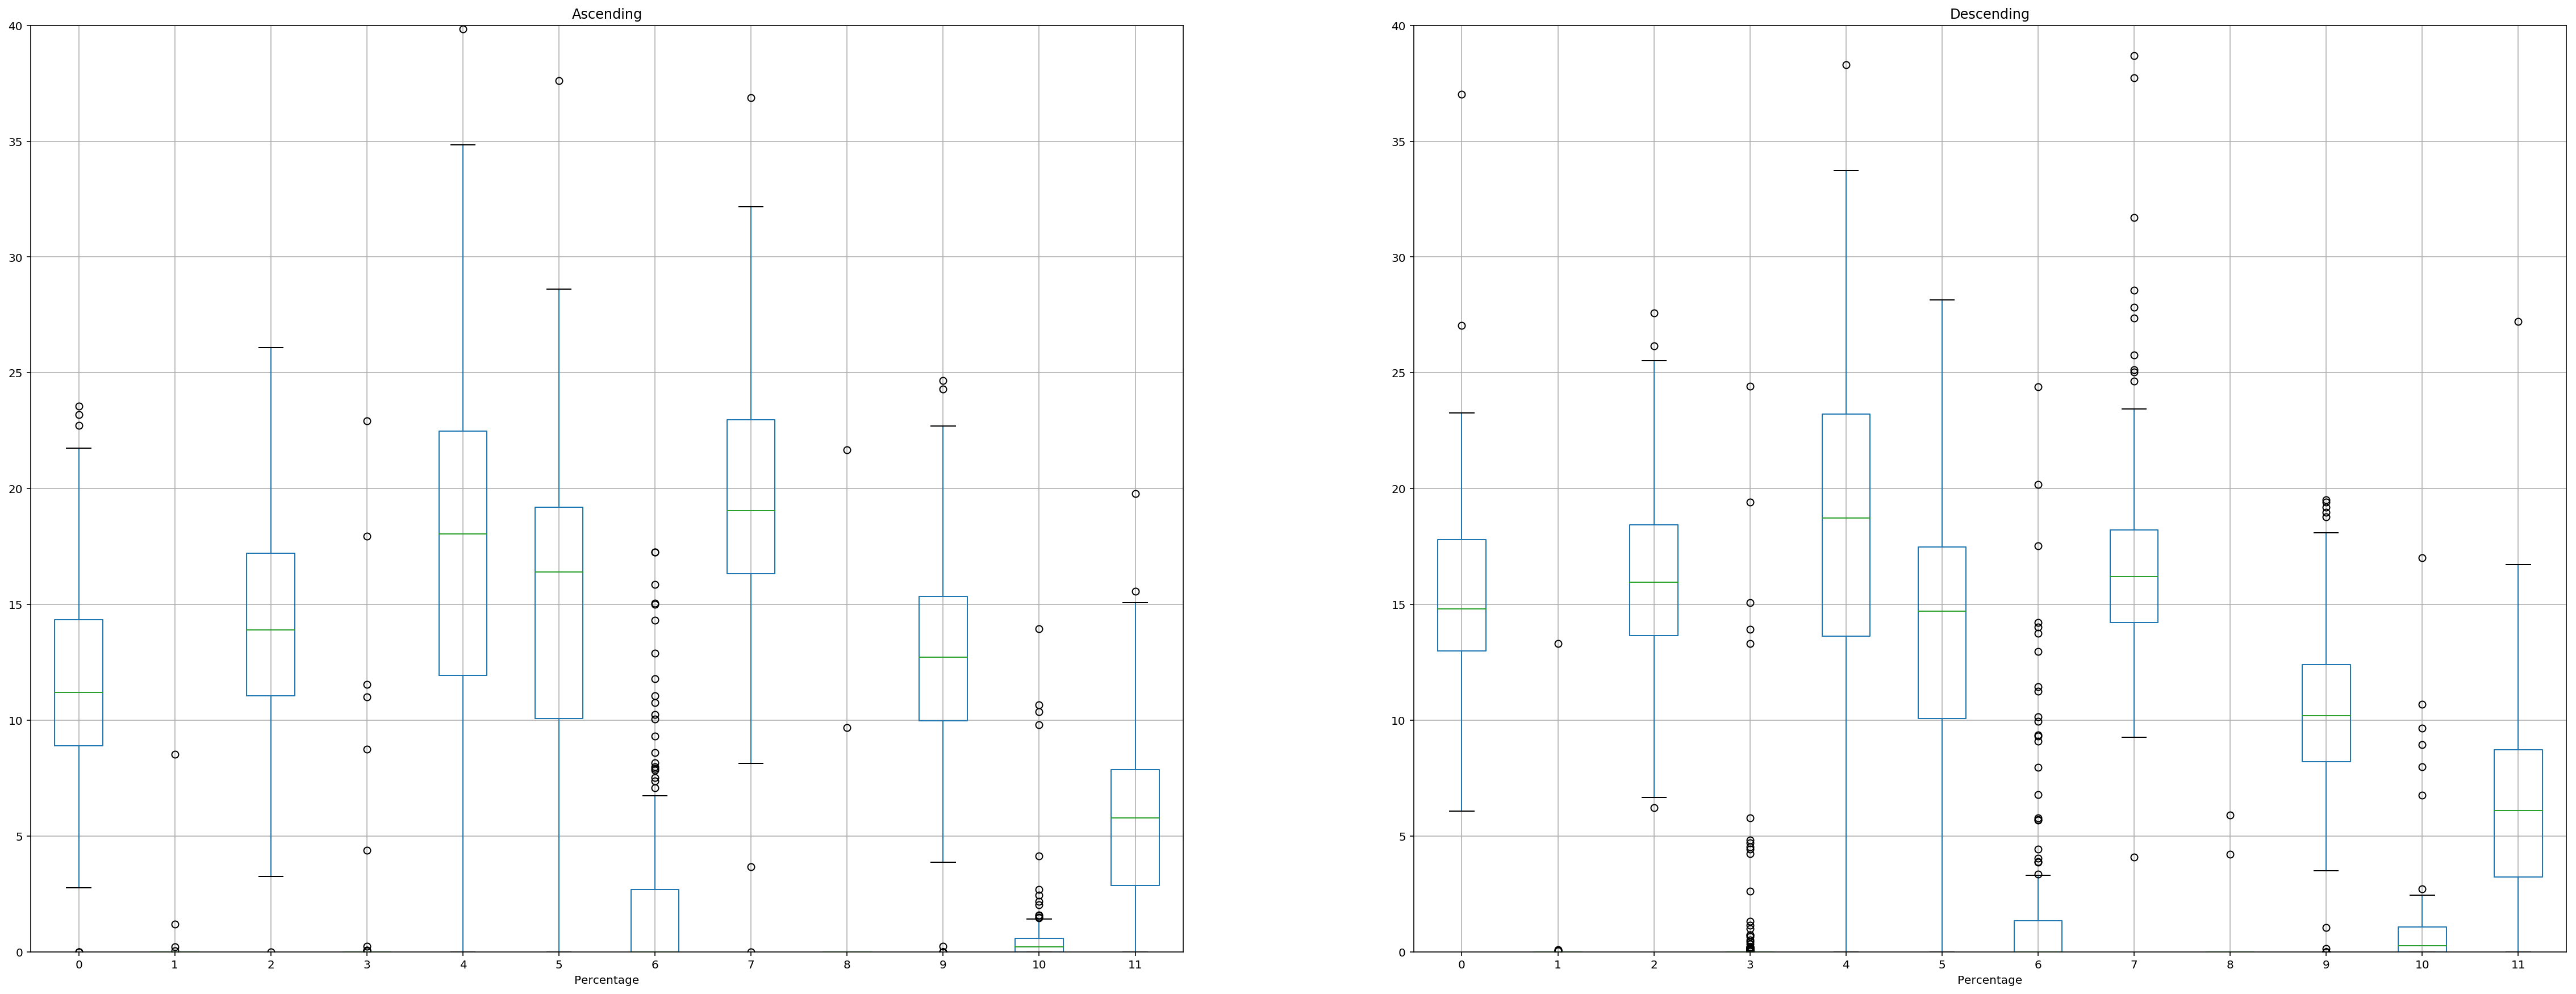

In [7]:
f, axs = plt.subplots(1,2,figsize=(40,15))

axs[0] = pitchclass_df_asc.boxplot(ax=axs[0])
axs[1] = pitchclass_df_desc.boxplot(ax=axs[1])

axs[0].set_title("Ascending")
axs[0].set_xlabel("Pitch Class")
axs[0].set_xlabel("Percentage")
axs[0].set_ylim(0, 40)

axs[1].set_title("Descending")
axs[1].set_xlabel("Pitch Class")
axs[1].set_xlabel("Percentage")
axs[1].set_ylim(0, 40)

filename = "Both_{0}_distance.png".format(DISTANCE_TH)

f.savefig(filename)

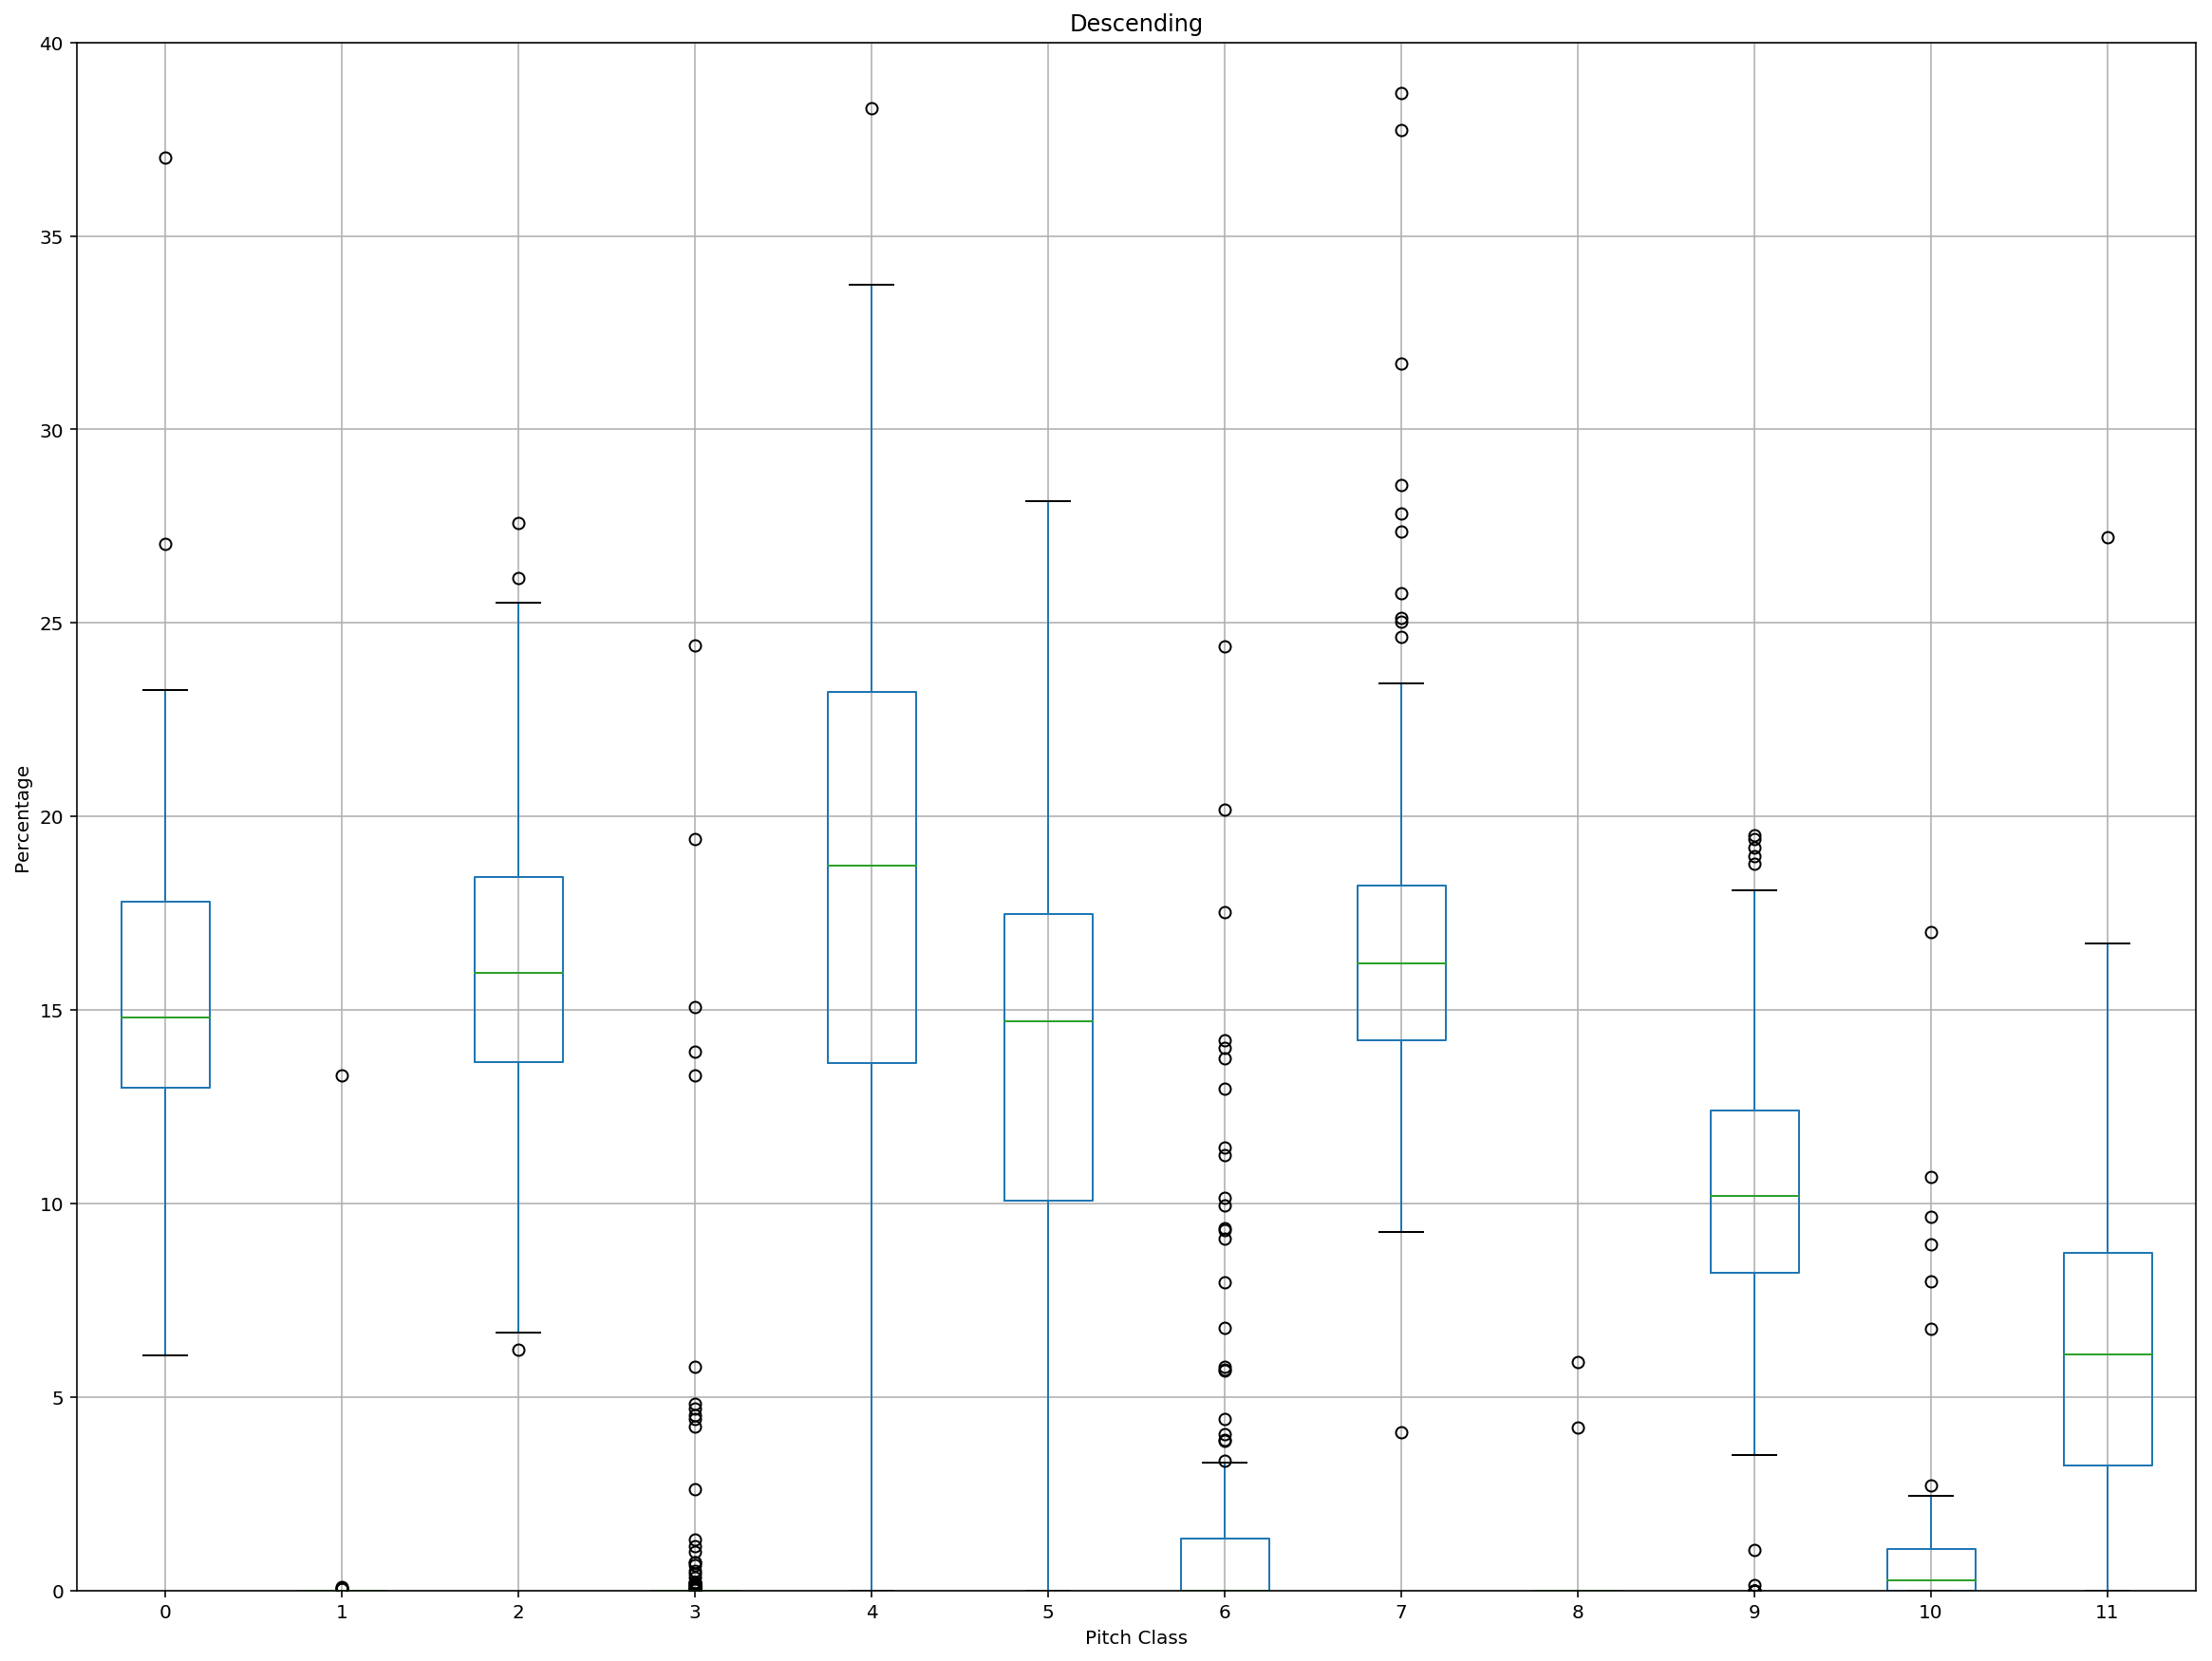

In [8]:
#ax = pitchclass_df_desc.boxplot(figsize = (20,15))

#plt.xlabel("Pitch Class")
#plt.ylabel("Percentage")
#plt.ylim(0, 40)
#plt.title("Descending")
#filename = "Descending_{0}_distance.png".format(DISTANCE_TH)
    
#plt.savefig(filename)

In [9]:
#print("{0}{1}{2}".format("Formatting files in ", SCORES_DIR, " and storing them in the scores folder..."))

#organize_xml_files(SCORES_DIR)

#print("Done")

In [10]:
#show_music21_settings()